<a href="https://colab.research.google.com/github/smizk/deeplearningstuff/blob/main/lab3transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#=======================================================================
# File Name : lab3transferlearning.ipynb
#=======================================================================
#
# $Auther:  ante0107
# $Date:    24-04-2021 

import tensorflow as tf
import numpy as np

In [2]:
# Data handle
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
num_classes = 10 # 10 types of clothing in the dataset
input_shape = (28, 28, 1)
ps = 72 # pixel size

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

print("train_images shape:", x_train.shape, 'type: ', type(x_train))
print("vali_images shape:", x_val.shape, 'type: ', type(x_val))
print("test_images shape:", x_test.shape, 'type: ', type(x_test))

4423680/4422102 [==============================] - 0s 0us/step
train_images shape: (54000, 28, 28) type:  <class 'numpy.ndarray'>
vali_images shape: (6000, 28, 28) type:  <class 'numpy.ndarray'>
test_images shape: (10000, 28, 28) type:  <class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


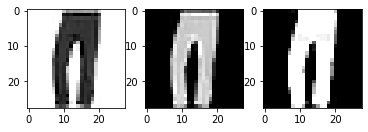

In [3]:
import matplotlib.pyplot as plt

tmp = x_train[0] # plot example

fig, axs = plt.subplots(1,3) 
axs[0].imshow(tmp, cmap=plt.cm.binary)
# convert image to rgb, i.e. 3 channels
tmp = tf.image.grayscale_to_rgb(tf.convert_to_tensor(np.expand_dims(tmp, -1)))
axs[1].imshow(tmp)
tmp = tf.keras.utils.normalize(tmp, axis=1) # normalize from the [0, 255] pixel values
axs[2].imshow(tmp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'New input image')

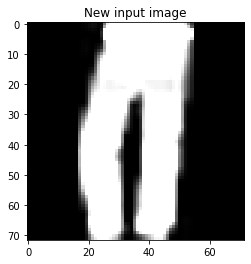

In [4]:
tmp = tf.image.resize_with_pad(tmp, ps, ps, antialias=False) # Resize 
plt.imshow(tmp)
plt.title('New input image')

In [5]:
def reshape_data(data):
  data = data.reshape(data.shape[0], 28, 28, 1)
  data = tf.image.grayscale_to_rgb(tf.convert_to_tensor(data))
  data = tf.keras.utils.normalize(data, axis=1)
  data = tf.image.resize_with_pad(data, ps, ps, antialias=False)
  return data

In [6]:
# Normalize the images.
x_train = reshape_data(x_train)
x_val = reshape_data(x_val)
x_test = reshape_data(x_test)
print("train_images shape:", x_train.shape, 'type: ', type(x_train))
print("vali_images shape:", x_val.shape, 'type: ', type(x_val))
print("test_images shape:", x_test.shape, 'type: ', type(x_test))

# convert class vectors to binary class matrice, this is because we use loss function "categorical_crossentropy"
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

train_images shape: (54000, 72, 72, 3) type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
vali_images shape: (6000, 72, 72, 3) type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
test_images shape: (10000, 72, 72, 3) type:  <class 'tensorflow.python.framework.ops.EagerTensor'>


In [7]:
# Creating the model, source: https://sodocumentation.net/keras/topic/10887/transfer-learning-and-fine-tuning-using-keras
input_shape = (ps, ps, 3) # new input shape
 
vgg_model = tf.keras.applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=input_shape)
vgg_model.summary()
# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

print(layer_dict.keys())

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 36, 36, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 36, 36, 128)       147584    
______________________________________________________________

In [8]:
# first 
# # Getting output tensor of the last VGG layer that we want to include
# x = layer_dict['block3_pool'].output # lets start from block 3

# # Stacking a new simple convolutional network on top of it
# x = tf.keras.layers.BatchNormalization(scale=False, axis=3)(x) # regularization method
# x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# see below

In [9]:
# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block1_pool'].output # lets start from block 2
# Stacking a new simple convolutional network on top of it
# x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.BatchNormalization(scale=False, axis=3)(x) # regularization method
# #x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
#x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
#x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu')(x)
#x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
#x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [10]:
# Creating new model.
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=x, name='Beritbrutal')

# Make sure that the pre-trained bottom layers are not trainable
for layer in model.layers[:4]:
    layer.trainable = False

#opt = tf.keras.optimizers.Adam(learning_rate=0.005)
# Do not forget to compile it
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

model.summary()

Model: "Beritbrutal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 36, 64)        192       
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 36, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 128)       

In [11]:
# Lets train the model
# create callbacks
# callbacks = [ 
#   tf.keras.callbacks.ModelCheckpoint('best_model', monitor='val_accuracy', verbose=1, save_best_only=True),
#   tf.keras.callbacks.ReduceLROnPlateau( factor = 0.1, patience = 3, min_lr = 0.00001, verbose = 1 )
#]  

epochs = 20 
batch_size = 100
hist = model.fit(x_train, y_train, 
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(x_val, y_val))

Epoch 1/20
540/540 [==============================] - 47s 30ms/step - loss: 2.3027 - accuracy: 0.0997 - val_loss: 2.3026 - val_accuracy: 0.1003
Epoch 2/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3026 - accuracy: 0.1009 - val_loss: 2.3028 - val_accuracy: 0.1022
Epoch 3/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.1004 - val_loss: 2.3026 - val_accuracy: 0.0978
Epoch 4/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3028 - val_accuracy: 0.0978
Epoch 5/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.0978 - val_loss: 2.3027 - val_accuracy: 0.0945
Epoch 6/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.0975 - val_loss: 2.3028 - val_accuracy: 0.0947
Epoch 7/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3026 - accuracy: 0.1023 - val_loss: 2.3028 - val_accuracy:

In [12]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 2s 7ms/step - loss: 2.3026 - accuracy: 0.1000
Test loss: 2.302605390548706
Test accuracy: 0.10000000149011612


In [13]:
model.fit(x_train, y_train, 
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(x_val, y_val))

Epoch 1/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.1000 - val_loss: 2.3028 - val_accuracy: 0.0977
Epoch 2/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.0981 - val_loss: 2.3028 - val_accuracy: 0.0947
Epoch 3/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.0984 - val_loss: 2.3027 - val_accuracy: 0.0945
Epoch 4/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.0985 - val_loss: 2.3028 - val_accuracy: 0.0978
Epoch 5/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3027 - val_accuracy: 0.0978
Epoch 6/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3027 - val_accuracy: 0.0945
Epoch 7/20
540/540 [==============================] - 16s 29ms/step - loss: 2.3027 - accuracy: 0.0975 - val_loss: 2.3027 - val_accuracy:

Trying to imporve the model: 
Total params: 2,035,786
Trainable params: 298,634
Non-trainable params: 1,737,152

1.   First try resulted in a Test loss: 0.68 and Test accuracy: 0.87. I had a previous run which was slightly better but I added another batch normalization layer after the flatten layer because it looked like it was overfitting. I had the same number of ephocs (30) for both and it still look like it is overfitting slightly. 
2.  Test changing hyperparameters:
  *   batch size: 10 chrashed - to little RAM
  *   batch size: 20; results: pretty bad, Acc: 0.1 loss: 2.3
  *   batch size: 30 and 40 : pretty much exactly the same loss: 0.58 acc: 0.8668

3. Lets try a bunch of networks. The test results from the models below are not compareable one-to-one, as there are some differences in there hyperparameters (mostly batch size). However, we can make some assumptions about the performances when from the differences in network layers and transfered layers.

In Model 1, I transfered only the first 4 layers. These filters should still be relativly *simple* and mostly consist of edge detectors. This should do well in our network as the MNIST Fashion consist of rather small images and non colour images.



### Model 1
input_1 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 36, 64)        192       
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      

Total params: 388,202
Trainable params: 349,354
Non-trainable params: 38,848
_________________________________________________________________

Test loss: 0.32943540811538696
Test accuracy: 0.8952999711036682

### Model 2
input_1 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 36, 36, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 36, 36, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 128)       384       
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 18, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               1700      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010  
    
Total params: 507,718
Trainable params: 247,302
Non-trainable params: 260,416
_________________________________________________________________

Test loss: 0.4069257974624634
Test accuracy: 0.8859000205993652

another 40 : epochs 

### Model 3
input_1 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 36, 36, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 36, 36, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 128)       384       
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      

Total params: 999,434
Trainable params: 739,018
Non-trainable params: 260,416
_________________________________________________________________
Test loss: 0.34300681948661804
Test accuracy: 0.8819000124931335




### Model 4
input_1 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 36, 36, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 36, 36, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 18, 128)       384       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 512)         1180160   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      

Total params: 2,151,242
Trainable params: 1,890,826
Non-trainable params: 260,416
_________________________________________________________________

Test loss: 0.3965311348438263
Test accuracy: 0.8539999723434448

changed batch_size=15 
Test loss: 0.49344849586486816
Test accuracy: 0.8592000007629395


### Model 5

input_1 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 36, 36, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 36, 36, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 128)       384       
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 512)         1180160   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      

Total params: 2,151,242
Trainable params: 1,890,826
Non-trainable params: 260,416
_________________________________________________________________

Test loss: 0.4669555127620697
Test accuracy: 0.8830000162124634


### Model 6

input_1 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 36, 36, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 36, 36, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 128)       384       
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 512)         1180160   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               102600    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2010      


Total params: 1,988,066
Trainable params: 1,727,650
Non-trainable params: 260,416
_________________________________________________________________
Test loss: 0.431942880153656
Test accuracy: 0.8810999989509583


### Model 7

input_1 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 36, 36, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 36, 36, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 18, 18, 256)       295168    
_________________________________________________________________
block3_conv2 (Conv2D)        (None, 18, 18, 256)       590080    
_________________________________________________________________
block3_conv3 (Conv2D)        (None, 18, 18, 256)       590080    
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 9, 9, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 256)         768       
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 256)         590080    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 256)         590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      

Total params: 3,446,346
Trainable params: 1,710,346
Non-trainable params: 1,736,000
_________________________________________________________________
Test loss: 0.5607700347900391
Test accuracy: 0.8615000247955322
